In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D
import paths


def build_ratios_table(tol:float=1e-5)->dict:
    """
    Create a table of small integer ratios 
    with a tolerance used to determine if the ratio between two 
    periods is close to a small integer ratio.

    Parameters:
        tol (float): 
        The tolerance used to determine if the ratio between 
        the two periods is close to a small integer ratio.
        Default is 1e-5

    Returns:
        dict: A dictionary of ratios with the key as the ratio
        and value as a tuple of numerator and denominator
    """

    ratios = {}
    
    for i in range(1, int(np.sqrt(1/tol))):
        for j in range(1, int(np.sqrt(1/tol))):
            ratio = round(i/j, int(-np.log10(tol)))
            if ratio not in ratios:
                ratios[ratio] = (i,j)
    return ratios


def is_spin_orbit_commensurable(period1:float, period2:float,  ratios:dict, 
                                tol:float=1e-5,)->tuple:
    """
    Check for spin-orbit commensurability between two periods.
    Spin-orbit commensurability occurs when the ratio between the rotation period
    of a celestial body and its orbital period around another body is close to a 
    small integer ratio.

    Parameters:
    ----------
        period1 (float):
            The rotation period of a celestial body.
        period2 (float): 
            The orbital period around another body.
        tol (float): 
            The tolerance used to determine if the ratio between 
            the two periods is close to a small integer ratio.
            Default is 1e-5
        ratios (dict):
            A dictionary of ratios with the key as the ratio
            and value as a tuple of numerator and denominator


    Returns:
    -------
        tuple:  A tuple containing,
                A boolean value indicating whether the ratio is close to small integer ratio
                The closest ratio in the form of tuple (i,j) where i,j are small integers.
    """
    ratio = round(period1/period2, int(-np.log10(tol)))
    
    if ratio in ratios:
        sor = ratios[ratio]
        return (True, sor, np.abs((period1/period2-ratio)/ratio))
    else:
        closest_ratio = min(ratios, key=lambda x: abs(x-ratio))
        sor = ratios[closest_ratio]
        return (False, ratios[closest_ratio], np.abs((period1/period2-closest_ratio)/closest_ratio))



In [2]:
# read in results table
df = pd.read_csv(paths.data / "results.csv")


# drop rows with TIC 67646988 and 236387002, the brown dwarfs
df = df[df.TIC != "67646988" ]
df = df[df.TIC != "236387002" ]

# the old Kepler-411 instance
df = df[df.TIC != "399954349(c)" ]

# GJ 1061 because rotation is unclear
df = df[df.TIC != "79611981" ]


In [3]:
tol = 0.01
ratios = build_ratios_table(tol=tol)
df["spin_orbit_commensurable"] = df.apply(lambda x: is_spin_orbit_commensurable(x['st_rotp'], x['orbper_d'], 
            ratios, tol=tol)[0], axis=1)
df["closest_ratio_num"] = df.apply(lambda x: is_spin_orbit_commensurable(x['st_rotp'], x['orbper_d'],
            ratios, tol=tol)[1][0], axis=1)
df["closest_ratio_den"] = df.apply(lambda x: is_spin_orbit_commensurable(x['st_rotp'], x['orbper_d'],
            ratios, tol=tol)[1][1], axis=1)
df["ratio_error"] = df.apply(lambda x: is_spin_orbit_commensurable(x['st_rotp'], x['orbper_d'],
            ratios, tol=tol)[2], axis=1)

In [4]:
# df["color"] = df.apply(lambda x: "red" if x["ratio_error"]<0.05 else "blue", axis=1)
# df["marker"] = df.apply(lambda x: "X" if x["ratio_error"]<0.05 else "o", axis=1)
df["color"] = "blue"
df["marker"] = "o"

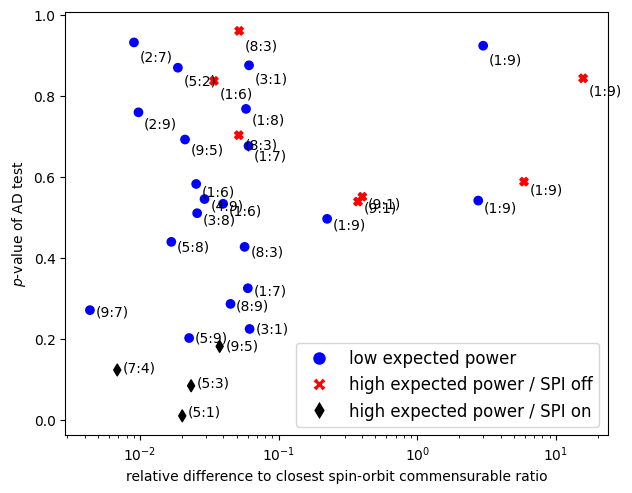

In [15]:
# label all that are expected with higher power than TOI-540
toi540 = df.loc[df.ID=="TOI-540","p_spi_sb_bp1_norm"].values[0]
cond = ((df["p_spi_sb_bp1_norm"]>toi540) & (df["mean"]>.3))
# liste = df.loc[cond, "ID"].values
df.loc[cond, "color"] = "red"
df.loc[cond, "marker"] = "X"

cond = df["mean"] < .2
df.loc[cond, "color"] = "k"
df.loc[cond, "marker"] = "d"

plt.figure(figsize=(7,5.5))
for marker, g in df.groupby("marker"):
    plt.scatter(g["ratio_error"], g["mean"],#g["closest_ratio_num"] + g["closest_ratio_den"],
               color=g["color"], alpha=1., marker=marker)

valuelegend = [Line2D([0], [0], marker='o', color='w',
                   markerfacecolor='b', markersize=10),
                   Line2D([0], [0], marker='X', color='w',
                   markerfacecolor='red', markersize=10),
                   Line2D([0], [0], marker='d', color='w',
                   markerfacecolor='black', markersize=10),]

valuelabels = [ r"low expected power",
                    r"high expected power / SPI off",
                    r"high expected power / SPI on"]


for i, row in df.iterrows():
  
    plt.annotate(f"({row.closest_ratio_den}:{row.closest_ratio_num})",
                    (row.ratio_error*1.1, row["mean"]*.95))

plt.legend(valuelegend, valuelabels, loc=4, fontsize=12, frameon=True)

plt.xlabel("relative difference to closest spin-orbit commensurable ratio")
# plt.ylabel("numerator + denominator")
plt.ylabel(r"$p$-value of AD test")

# plt.xlim(0,1)
plt.xscale("log")
plt.yscale("log")
# plt.ylim(0,11)

Text(0, 0.5, 'number of star-planet systems')

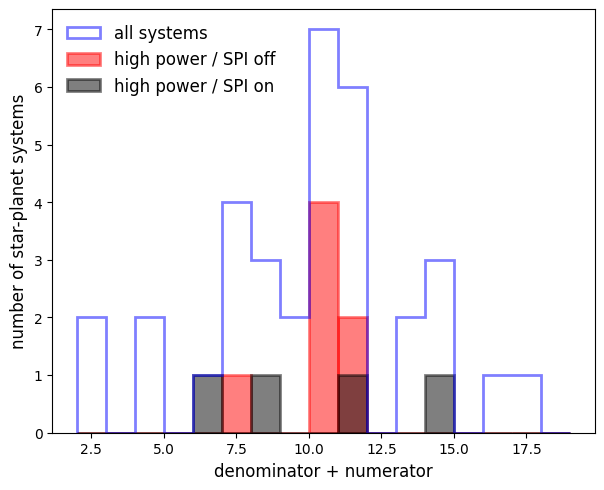

In [14]:
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(7,5.5))

# bins = np.logspace(-3, 1.2, 10)
bins = np.arange(2,20)




# label all that are expected with higher power than TOI-540
toi540 = df.loc[df.ID=="TOI-540","p_spi_sb_bp1_norm"].values[0]

# cond = (df["p_spi_sb_bp1_norm"]<toi540)
(df["closest_ratio_num"] + df["closest_ratio_den"]).hist(bins=bins, alpha=0.5, edgecolor="b", color="b",
                                    label="all systems", ax=ax, histtype="step",
                                    linewidth=2, grid=False)

cond = ((df["p_spi_sb_bp1_norm"]>toi540) & (df["mean"]>.3))
# liste = df.loc[cond, "ID"].values
(df.loc[cond, "closest_ratio_num"] + df.loc[cond, "closest_ratio_den"]).hist(bins=bins, alpha=0.5, edgecolor="r", color="r",
                                 label="high power / SPI off", ax=ax, #histtype="step",
                                 linewidth=2, grid=False)

cond = df["mean"] < .2
(df.loc[cond, "closest_ratio_num"] + df.loc[cond, "closest_ratio_den"]).hist(bins=bins, alpha=0.5, edgecolor="k", color="k",
                                 label="high power / SPI on", ax=ax, #histtype="step",
                                 linewidth=2, grid=False)


plt.legend(loc=2, fontsize=12, frameon=False)


plt.xlabel('denominator + numerator',#"relative difference to closest spin-orbit commensurable ratio",
           fontsize=12)
plt.ylabel("number of star-planet systems",
           fontsize=12)

# plt.xlim(2e-3,20)
# plt.xscale("log")
# plt.yscale("log")
# plt.ylim(0,11)

In [113]:
df.sort_values("p_spi_sb_bp1_norm", ascending=True).tail(20)

,TIC,number_of_flares,mean,std,moresectors,futuresectors,ID,KOI,KIC,st_rotp,...,st_rad_bibkey,pl_orbsmax_bibkey,st_lum_bibkey,pl_radj_bibkey,spin_orbit_commensurable,closest_ratio_num,closest_ratio_den,ratio_error,color,marker
9,206548902,5,0.69250,0.199753,1.0,69,GJ 3082,NaN,NaN,6.5500,...,stassun2019revised,feng2020searcha,stassun2019revised,chen2017probabilistic,False,5,9,0.021137,blue,o
17,278892590,39,0.54555,0.046461,NaN,NaN,TRAPPIST-1,NaN,EPIC 200164267,3.3000,...,agol2021refining,agol2021refining,agol2021refining,agol2021refining,False,9,4,0.029229,blue,o
10,218263393,9,0.67665,0.241917,1.0,66,GJ 674,NaN,NaN,34.8500,...,stassun2019revised,bonfils2007harps,fouesneau2022gaia,chen2017probabilistic,False,7,1,0.060670,blue,o
19,28230919,3,0.53385,0.008185,3.0,"54,55,56",HAT-P-11,NaN,NaN,28.1600,...,yee2018hatp11,yee2018hatp11,stassun2019revised,yee2018hatp11,False,6,1,0.039787,blue,o
15,273379660,3,0.76815,0.029149,NaN,NaN,Kepler-862,1491.0,NaN,26.6560,...,morton2016false,thompson2018planetary,fouesneau2022gaia,morton2016false,False,8,1,0.058226,blue,o
31,468989066,3,0.51060,0.018513,1.0,61,K2-354,NaN,NaN,10.3900,...,deleon202137,deleon202137,stassun2019revised,deleon202137,False,8,3,0.025856,blue,o
8,200322593,14,0.08445,0.009041,0.0,NaN,TOI-540,NaN,NaN,0.7261,...,ment2021toi,ment2021toi,ment2021toi,ment2021toi,False,3,5,0.023389,blue,o
5,164884002,9,0.83730,0.018876,0.0,NaN,Kepler-55,904.0,NaN,13.7200,...,rowe2014validation,rowe2014validation,fouesneau2022gaia,rowe2014validation,False,6,1,0.034177,blue,o
25,434226736,3,0.18165,0.030605,0.0,NaN,K2-25,NaN,NaN,1.8780,...,stefansson2020habitable,stefansson2020habitable,stefansson2020habitable,stefansson2020habitable,False,5,9,0.037592,blue,o
33,63126862,27,0.84370,0.028846,1.0,54,Kepler-42,961.0,NaN,68.2300,...,muirhead2012characterizing,muirhead2012characterizing,muirhead2012characterizing,muirhead2012characterizing,False,9,1,15.724819,blue,o


In [24]:
def ratio(rot, orb):
    """Calculate the ratio of rotation period to orbital period.

    Parameters
    ----------
    rot : float
        Rotation period in days.
    orb : float
        Orbital period in days.

    Returns
    -------
    ratio : float
        Ratio of rotation period to orbital period.
    """
    if rot > orb:
        return rot/orb
    elif rot < orb:
        return orb/rot
